In [1]:
# 라이브러리 버전 확인

import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
# 데이터 준비

import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터 라벨링 의문점 :  
0이 부정, 1이 긍정으로 판단 된다 (0번, 3번이 부정적)  
2번에 '추천한다'는 코멘트가 있음에도 부정이라고 판단한 이유가 뭘까?

In [3]:
# 데이터 로더 구성

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #중복 데이터 삭제
    train_data = train_data.dropna(how = 'any')                   # 결측치 삭제
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 정규 표현식을 통한 한글 외 문자 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_1806/2996712651.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
/tmp/ipykernel_1806/2996712651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
word_to_index = {k:(v) for k,v in word_to_index.items()} # (v+3) -> v로 변경

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])


# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))



<BOS>
더 빙 진짜 짜증 나 네요 목소리


In [7]:
print(index_to_word)

{3: '<UNUSED>', 4: '영화', 5: '다', 6: '고', 7: '하', 8: '을', 9: '보', 10: '게', 11: '지', 12: '있', 13: '없', 14: '좋', 15: '나', 16: '었', 17: '만', 18: '는데', 19: '너무', 20: '봤', 21: '적', 22: '안', 23: '정말', 24: '로', 25: '것', 26: '음', 27: '아', 28: '네요', 29: '어', 30: '재밌', 31: '지만', 32: '같', 33: '진짜', 34: '에서', 35: '했', 36: '기', 37: '네', 38: '않', 39: '점', 40: '거', 41: '았', 42: '수', 43: '되', 44: '면', 45: 'ㅋㅋ', 46: '인', 47: '말', 48: '연기', 49: '주', 50: '최고', 51: '내', 52: '평점', 53: '이런', 54: '던', 55: '어요', 56: '할', 57: '왜', 58: '겠', 59: '스토리', 60: '해', 61: 'ㅋㅋㅋ', 62: '습니다', 63: '듯', 64: '아니', 65: '드라마', 66: '생각', 67: '더', 68: '그', 69: '싶', 70: '사람', 71: '때', 72: '감동', 73: '배우', 74: '함', 75: '본', 76: '까지', 77: '뭐', 78: '알', 79: '만들', 80: '내용', 81: '볼', 82: '보다', 83: '감독', 84: '라', 85: '재미', 86: '그냥', 87: '시간', 88: '지루', 89: '중', 90: '재미있', 91: '였', 92: '잼', 93: '년', 94: '사랑', 95: '못', 96: '재미없', 97: '냐', 98: '쓰레기', 99: '서', 100: '라고', 101: '니', 102: '면서', 103: '다시', 104: '번', 105: '나오', 106: '하나', 107: '작

In [8]:
# maxlen 계산하기

total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  13.718233430088207
문장길이 최대 :  83
문장길이 표준편차 :  11.469848902034261
pad_sequences maxlen :  36
전체 문장의 0.9340019146202243%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 36)


In [10]:
# 학습 데이터 분리

split_ratio = 0.3
split_num = int(len(X_train) * split_ratio)

# validation set 10000건 분리
x_val = X_train[:split_num]   
y_val = y_train[:split_num]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[split_num:]  
partial_y_train = y_train[split_num:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(102328, 36)
(102328,)


### 모델 설계 및 학습

모델 1 : LSTM

In [83]:
# 모델 1 : LSTM

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [84]:
# 모델 학습

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 3s 7ms/step - loss: 0.5262 - accuracy: 0.7687 - val_loss: 0.3824 - val_accuracy: 0.8326
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3588 - accuracy: 0.8459 - val_loss: 0.3611 - val_accuracy: 0.8411
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3321 - accuracy: 0.8589 - val_loss: 0.3655 - val_accuracy: 0.8396
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3209 - accuracy: 0.8648 - val_loss: 0.3724 - val_accuracy: 0.8371
Epoch 5/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3113 - accuracy: 0.8696 - val_loss: 0.3679 - val_accuracy: 0.8393
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3033 - accuracy: 0.8734 - val_loss: 0.3687 - val_accuracy: 0.8385
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.2971 - accuracy: 0.8753 - val_loss: 0.3754 - val_accuracy: 0.8387
Epoch 

In [85]:
# 모델 평가

results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.4702 - accuracy: 0.8278
[0.470150887966156, 0.827837347984314]


In [87]:
# 모델 2 : 1D convolution

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [88]:
print(partial_x_train.shape)
# 입력 데이터 차원 변경 (2차원 -> 3차원)

partial_x_train_ex = np.expand_dims(partial_x_train, axis=-1)  # (102328, 36) -> (102328, 36, 1)
print(partial_x_train_ex.shape)

(102328, 36)
(102328, 36, 1)


In [89]:
# 모델 학습

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2= model2.fit(partial_x_train_ex,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 2s 6ms/step - loss: 0.6116 - accuracy: 0.6311 - val_loss: 0.5095 - val_accuracy: 0.7257
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4776 - accuracy: 0.7525 - val_loss: 0.4901 - val_accuracy: 0.7402
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4439 - accuracy: 0.7719 - val_loss: 0.4940 - val_accuracy: 0.7407
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.7867 - val_loss: 0.4999 - val_accuracy: 0.7386
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3950 - accuracy: 0.8005 - val_loss: 0.5170 - val_accuracy: 0.7370
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3694 - accuracy: 0.8140 - val_loss: 0.5362 - val_accuracy: 0.7341
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3445 - accuracy: 0.8267 - val_loss: 0.5636 - val_accuracy: 0.7300
Epoch 

In [90]:
# 모델 평가

results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 2s - loss: 1.0667 - accuracy: 0.7030
[1.0667097568511963, 0.7030128240585327]


모델 3 : GlobalMaxPooling1D

In [91]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [92]:
# 모델 학습

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 0.6146 - accuracy: 0.7110 - val_loss: 0.4804 - val_accuracy: 0.8032
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.4092 - accuracy: 0.8269 - val_loss: 0.3799 - val_accuracy: 0.8307
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3452 - accuracy: 0.8536 - val_loss: 0.3652 - val_accuracy: 0.8360
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3135 - accuracy: 0.8685 - val_loss: 0.3634 - val_accuracy: 0.8383
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2902 - accuracy: 0.8803 - val_loss: 0.3667 - val_accuracy: 0.8384
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2717 - accuracy: 0.8898 - val_loss: 0.3738 - val_accuracy: 0.8383
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2554 - accuracy: 0.8977 - val_loss: 0.3814 - val_accuracy: 0.8373
Epoch 

In [93]:
# 모델 평가

results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.5666 - accuracy: 0.8156
[0.5665583610534668, 0.8156315684318542]


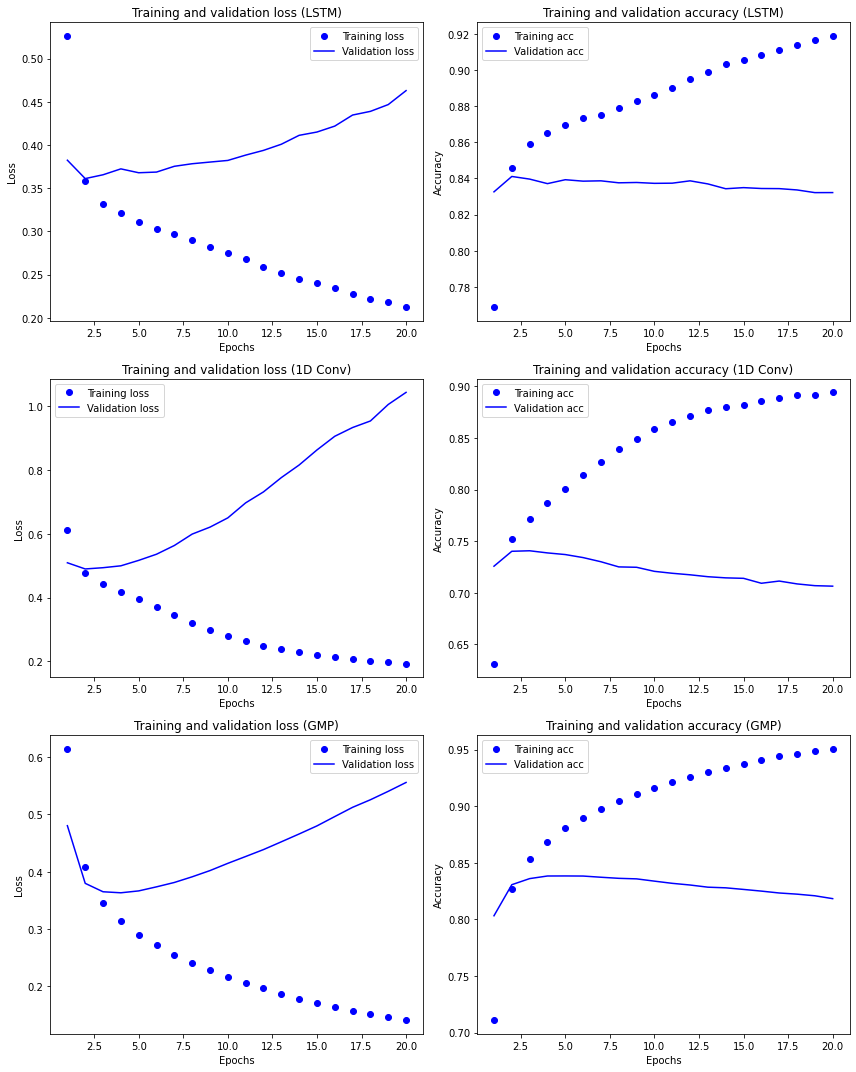

In [98]:
import matplotlib.pyplot as plt

acc1 = history_dict1['accuracy']
val_acc1 = history_dict1['val_accuracy']
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']

acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc1) + 1)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3행 2열로 서브플롯 생성

# LSTM
axes[0, 0].plot(epochs, loss1, 'bo', label='Training loss')
axes[0, 0].plot(epochs, val_loss1, 'b', label='Validation loss')
axes[0, 0].set_title('Training and validation loss (LSTM)')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].plot(epochs, acc1, 'bo', label='Training acc')
axes[0, 1].plot(epochs, val_acc1, 'b', label='Validation acc')
axes[0, 1].set_title('Training and validation accuracy (LSTM)')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# 1D Conv
axes[1, 0].plot(epochs, loss2, 'bo', label='Training loss')
axes[1, 0].plot(epochs, val_loss2, 'b', label='Validation loss')
axes[1, 0].set_title('Training and validation loss (1D Conv)')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].plot(epochs, acc2, 'bo', label='Training acc')
axes[1, 1].plot(epochs, val_acc2, 'b', label='Validation acc')
axes[1, 1].set_title('Training and validation accuracy (1D Conv)')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# GMP
axes[2, 0].plot(epochs, loss3, 'bo', label='Training loss')
axes[2, 0].plot(epochs, val_loss3, 'b', label='Validation loss')
axes[2, 0].set_title('Training and validation loss (GMP)')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].legend()

axes[2, 1].plot(epochs, acc3, 'bo', label='Training acc')
axes[2, 1].plot(epochs, val_acc3, 'b', label='Validation acc')
axes[2, 1].set_title('Training and validation accuracy (GMP)')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


In [101]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [102]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
## from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

In [99]:
word_vectors

In [49]:
word_vectors.similar_by_word("끝")

[('히트맨', 0.8163067102432251),
 ('욕할', 0.8050025105476379),
 ('지미', 0.8048815727233887),
 ('짜내', 0.8048346638679504),
 ('왔', 0.8044472336769104),
 ('글씨', 0.803160548210144),
 ('리딕', 0.8014841675758362),
 ('그물', 0.8012136816978455),
 ('뚫', 0.8010220527648926),
 ('아앙', 0.8000919818878174)]

결과 좋지 않음..

In [50]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [76]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 36, 300)           3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/8
200/200 [==============================] - 4s 9ms/step - loss: 0.5271 - accuracy: 0.7405 - val_loss: 0.4259 - val_accuracy: 0.8168
Epoch 2/8
200/200 [==============================] - 1s 7ms/step - loss: 0.3803 - accuracy: 0.8393 - val_loss: 0.3715 - val_accuracy: 0.8373
Epoch 3/8
200/200 [==============================] - 1s 7ms/step - loss: 0.3417 - accuracy: 0.8571 - val_loss: 0.3665 - val_accuracy: 0.8401
Epoch 4/8
200/200 [==============================] - 1s 7ms/step - loss: 0.3201 - accuracy: 0.8680 - val_loss: 0.3607 - val_accuracy: 0.8419
Epoch 5/8
200/200 [==============================] - 1s 7ms/step - loss: 0.3053 - accuracy: 0.8751 - val_loss: 0.3647 - val_accuracy: 0.8415
Epoch 6/8
200/200 [==============================] - 1s 7ms/step - loss: 0.2928 - accuracy: 0.8811 - val_loss: 0.3642 - val_accuracy: 0.8419
Epoch 7/8
200/200 [==============================] - 1s 7ms/step - loss: 0.2811 - accuracy: 0.8868 - val_loss: 0.3681 - val_accuracy: 0.8427
Epoch 8/8
200

In [75]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7147 - accuracy: 0.8068
[0.7146655321121216, 0.8067619800567627]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


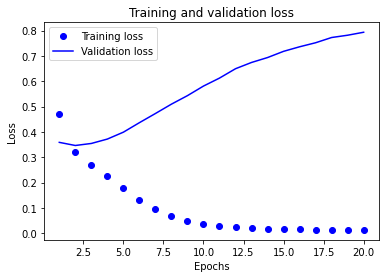

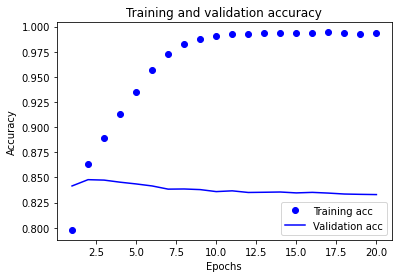

In [55]:
# 평가 지표 출력

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 확인

# 평가 지표 출력

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프로 확인

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, loss, 'bo', label='Training loss')
axes[0].plot(epochs, val_loss, 'b', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, acc, 'bo', label='Training acc')
axes[1].plot(epochs, val_acc, 'b', label='Validation acc')
axes[1].set_title('Training and validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


### 학습된 임베딩 레이어 분석

In [78]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [79]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [80]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 1.04922140e+00,  6.71914935e-01,  9.03152645e-01,  5.45006394e-01,
        2.37389892e-01,  3.47328544e-01,  3.13788742e-01,  8.52474153e-01,
        8.58231962e-01,  3.25187445e-01,  9.43883181e-01,  2.54522241e-03,
        9.23134565e-01,  3.73810858e-01,  9.13681090e-01,  8.23768258e-01,
        7.76095092e-02,  7.33019114e-01,  4.61557768e-02,  6.64023161e-01,
        7.21065402e-01,  6.70407116e-01,  9.12053943e-01,  1.99534342e-01,
        5.60043715e-02,  5.56144595e-01,  8.99281025e-01,  6.10603809e-01,
        2.38153800e-01,  1.22461975e-01,  5.52490950e-01,  6.39295638e-01,
        1.68293312e-01,  7.27197945e-01,  5.87459922e-01,  8.15720499e-01,
        8.40736985e-01,  8.04911137e-01,  2.58670896e-01,  7.19331920e-01,
        6.12182558e-01,  3.56571972e-01,  1.35018453e-01,  1.02660611e-01,
        9.72054780e-01,  9.63995576e-01,  1.02356362e+00,  1.13596827e-01,
        6.23439074e-01,  8.38889062e-01,  4.65363950e-01,  5.91890037e-01,
        2.99103558e-01,  

In [81]:
word_vectors.similar_by_word("끝")

[('라이프', 0.806310772895813),
 ('휴가', 0.7990289926528931),
 ('뿜', 0.7988048791885376),
 ('휴지', 0.7986727356910706),
 ('괴롭', 0.7970640659332275),
 ('다냐', 0.7955012321472168),
 ('미침', 0.7949945330619812),
 ('장녀', 0.7934845685958862),
 ('공무원', 0.7928391695022583),
 ('우와', 0.7925816774368286)]

결과 좋지 않음2